## Inside a Boiler - Slagging Prediction
#### https://opendata.edp.com/pages/challenges/#description

In [1]:
### Chec#from imblearn.combine import SMOTETomek
import pandas as pd 
import numpy as np 
from numpy import sort, sqrt, argsort, inf
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_recall_curve,confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

### Cargamos X_scaled_interpolated

In [2]:
X_scaled_interpolated_from_csv = pd.read_csv('../data/boiler_Y_train_data_scaled_interpolated.csv')

In [3]:
X_scaled_interpolated_from_csv.set_index('ID_sampling', inplace=True)

In [4]:
X_scaled_interpolated_from_csv

,TARGET,DAYS_TILL_SLAG,HOUR,DAY,MONTH,Active Power_median,Active Power_mean,Active Power_max,Active Power_min,Active Power_std,...,Air Heater #1 Differential Pressure_max,Air Heater #1 Differential Pressure_min,Air Heater #1 Differential Pressure_std,Air Heater #1 Differential Pressure_skew,Reheated Steam Temperature 1 @Outlet_median,Reheated Steam Temperature 1 @Outlet_mean,Reheated Steam Temperature 1 @Outlet_max,Reheated Steam Temperature 1 @Outlet_min,Reheated Steam Temperature 1 @Outlet_std,Reheated Steam Temperature 1 @Outlet_skew
ID_sampling,,,,,,,,,,,,,,,,,,,,,
01-01-00,0,0,0,1,1,0.315556,0.319098,0.305600,0.342672,-0.223289,...,-0.115931,-0.046446,-0.279965,0.544224,0.214093,0.219890,0.208735,0.226438,-0.182410,-0.106896
01-01-01,0,0,1,1,1,0.318278,0.319591,0.306575,0.336465,-0.202701,...,-0.108469,-0.033755,-0.241505,-0.413258,0.257228,0.257395,0.244705,0.269316,-0.394893,-0.386300
01-01-02,0,0,2,1,1,0.317615,0.319754,0.286789,0.344149,-0.267642,...,-0.121528,-0.021060,-0.310082,0.937290,0.256104,0.252800,0.233342,0.268102,-0.368736,-0.804519
01-01-03,0,0,3,1,1,0.315965,0.318521,0.292057,0.332920,-0.204081,...,-0.115931,-0.064581,-0.157281,-1.464765,0.216385,0.209147,0.206487,0.211628,-0.002055,-0.171798
01-01-04,0,0,4,1,1,0.329135,0.321204,0.372476,0.277699,0.113230,...,-0.033835,-0.104470,0.084728,-0.098153,0.182917,0.155309,0.182932,0.089825,1.060142,-0.943097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-31-19,0,0,19,31,12,-2.699895,-2.710722,-2.830760,-2.570387,-0.330922,...,-1.705630,-1.507947,-0.448039,0.714910,-0.340337,-0.345679,-0.357456,-0.333201,-0.171806,-0.242713
12-31-20,0,0,20,31,12,-2.709318,-2.705418,-2.747917,-2.592037,0.064814,...,-1.435083,-1.533333,0.328350,3.819047,-0.331949,-0.326868,-0.333481,-0.313031,-0.191312,1.236952
12-31-21,0,0,21,31,12,-2.708999,-2.726121,-2.841609,-2.617003,-0.226161,...,-1.711228,-1.533333,-0.407997,-1.798494,-0.342057,-0.341978,-0.370485,-0.313031,-0.539043,0.019109


## Aquí aún no metemos atributos de tiempo (por posible estacionalidad)
### Mantenemos 'DAYS_TILL_SLAG' para usarlo en la validación

In [5]:
X_scaled_interpolated = X_scaled_interpolated_from_csv

numeric_features = [x for x in X_scaled_interpolated.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]

In [6]:
### Stratified train-test split
from sklearn.model_selection import train_test_split

features_to_train_no_temp = [x for x in X_scaled_interpolated.columns if x not in ['TARGET', 'HOUR', 'DAY', 'MONTH']]
X_train, X_test, y_train, y_test=train_test_split(X_scaled_interpolated[features_to_train_no_temp], 
                                                  X_scaled_interpolated['TARGET'], test_size=0.20, stratify=X_scaled_interpolated['TARGET'])


### Esto nos hace ver la importancia de probar otro sampleo con el que tengamos más datos, a parte de probar el SMOTE para oversamplear; de hecho necesito los days until slag para la función de coste de EDP, y no puedo oversamplear (no puede generar ficticos days till slag, a priori) <font color='red'> Probar también con el parámetro 'scale_pos_weight' de XGBOOST para el desbalanceo </font> 

In [7]:

X_train_attributes = numeric_features 
X_test_attributes = numeric_features 

train_slagdays_to_concat = X_train['DAYS_TILL_SLAG']
test_slagdays_to_concat = X_test['DAYS_TILL_SLAG']


### EDP cost function to evaluate our training

In [42]:

features_to_train_on = numeric_features
len(features_to_train_on)

144

## Model feature importances

In [45]:
f = 'gain'
feature_importances = xgb_best_params.get_booster().get_score(importance_type= f)

feature_importances

{'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_mean': 7.3618539525,
 'Main Steam Turbine Control Valve #B_max': 5.982777598,
 'Secondary Air Row #5 (Side 2)_min': 5.21072328,
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_median': 5.7554569073333335,
 'Coal Feeder #1_mean': 6.90781784,
 'Main Steam Second Desuperheater Control Valve position (Side 2)_median': 7.878308295,
 'Active Power_median': 2.3815271036666665,
 'Boiler Outlet Pressure_max': 4.12917972,
 'Dynamic Coal Classifier Rotational Speed Coal Mill #3_median': 2.3863817066666666,
 'Boiler Furnace Pressure_std': 2.482228436666667,
 'Boiler Furnace Pressure_mean': 4.488096475,
 'Secondary Air Row #3 (Side 2)_median': 3.43906355,
 'Main Steam Turbine Control Valve #D_max': 4.516999563333333,
 'Main Steam Turbine Control Valve #B_skew': 0.247436523,
 'Main Steam Second Desuperheater Control Valve position (Side 2)_mean': 5.0980778933333335,
 'Secondary Air Row #3 (Side 2)_max': 2.758950393333333,
 'Flue Gas Induced Draft F

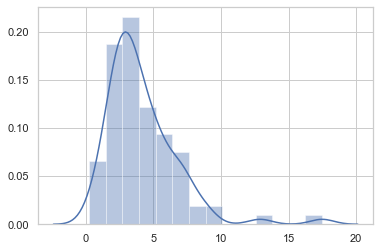

In [49]:
import seaborn as sns
sns.set(style="whitegrid")

f_importances = [value for key, value in feature_importances.items()]
ax = sns.distplot(f_importances)

In [13]:
selected_features_thr_3 = ['Flue Gas Induced Draft Fan #1 Blade Pitch Angle_mean',
 'Main Steam Turbine Control Valve #B_max',
 'Secondary Air Row #5 (Side 2)_min',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_median',
 'Coal Feeder #1_mean',
 'Main Steam Second Desuperheater Control Valve position (Side 2)_median',
 'Boiler Outlet Pressure_max',
 'Boiler Furnace Pressure_mean',
 'Secondary Air Row #3 (Side 2)_median',
 'Main Steam Turbine Control Valve #D_max',
 'Main Steam Second Desuperheater Control Valve position (Side 2)_mean',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_min',
 'Coal Feeder #1_min',
 'Secondary Air Fan #1 Temperature 2_min',
 'Air Heater #1 Differential Pressure_mean',
 'Boiler Outlet Pressure_median',
 'Coal Feeder #1_max',
 'Boosted Overfire Air (Side 1)_max',
 'Main Steam Turbine Control Valve #B_median',
 'Coal Feeder #5_mean',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #1_min',
 'Coal Feeder #5_min',
 'Main Steam Second Desuperheater Control Valve position (Side 2)_max',
 'Boiler Feedwater Pressure_max',
 'Boiler Outlet Pressure_min',
 'Boosted Overfire Air (Side 1)_min',
 'Air Heater #1 Differential Pressure_min',
 'Secondary Air Fan #1 Temperature 2_mean',
 'Coal Feeder #1_median',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_max',
 'Boiler Feedwater Pressure_median',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #2_min',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #3_min',
 'Total Atemperator Feedwater Flow_max',
 'Main Steam First Desuperheater Control Valve position (Side 2)_min',
 'Boiler Outlet Pressure_mean',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #1_max',
 'Main Steam Second Desuperheater Control Valve position (Side 1)_max',
 'Boiler Feedwater Pressure_std',
 'Secondary Air Row #3 (Side 2)_mean',
 'Active Power_mean',
 'Secondary Air Row #3 (Side 2)_std',
 'Air Heater #1 Differential Pressure_skew',
 'Main Steam First Desuperheater Control Valve position (Side 1)_std',
 'Boiler Outlet Pressure_std',
 'Air Heater #1 Differential Pressure_max',
 'Reheated Steam Temperature 1 @Outlet_std',
 'Boosted Overfire Air (Side 1)_mean',
 'Boosted Overfire Air (Side 1)_median',
 'Main Steam Turbine Control Valve #D_min',
 'Main Steam Second Desuperheater Control Valve position (Side 1)_mean',
 'Boosted Overfire Air (Side 2)_min',
 'Boiler Furnace Pressure_skew',
 'Coal Feeder #5_max']

In [14]:
selected_features_thr_4 = ['Flue Gas Induced Draft Fan #1 Blade Pitch Angle_mean',
 'Main Steam Turbine Control Valve #B_max',
 'Secondary Air Row #5 (Side 2)_min',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_median',
 'Coal Feeder #1_mean',
 'Main Steam Second Desuperheater Control Valve position (Side 2)_median',
 'Boiler Outlet Pressure_max',
 'Boiler Furnace Pressure_mean',
 'Main Steam Turbine Control Valve #D_max',
 'Main Steam Second Desuperheater Control Valve position (Side 2)_mean',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_min',
 'Coal Feeder #1_min',
 'Secondary Air Fan #1 Temperature 2_min',
 'Air Heater #1 Differential Pressure_mean',
 'Boiler Outlet Pressure_median',
 'Coal Feeder #1_max',
 'Boosted Overfire Air (Side 1)_max',
 'Main Steam Turbine Control Valve #B_median',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #1_min',
 'Main Steam Second Desuperheater Control Valve position (Side 2)_max',
 'Boiler Feedwater Pressure_max',
 'Boosted Overfire Air (Side 1)_min',
 'Secondary Air Fan #1 Temperature 2_mean',
 'Coal Feeder #1_median',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_max',
 'Boiler Feedwater Pressure_median',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #2_min',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #3_min',
 'Total Atemperator Feedwater Flow_max',
 'Main Steam First Desuperheater Control Valve position (Side 2)_min',
 'Boiler Outlet Pressure_mean',
 'Boiler Feedwater Pressure_std',
 'Active Power_mean',
 'Boosted Overfire Air (Side 1)_mean',
 'Boosted Overfire Air (Side 1)_median',
 'Coal Feeder #5_max']

## Cargamos ambos modelos a comparar

In [44]:
import pickle

file_data = r'..\models\xgb_best_params_right_boiler_Y_2.pkl'
file_data = open(file_data, 'rb')
xgb_best_params_edp_funct_model_boiler_Y_2 = pickle.load(file_data)
file_data.close()

file_data = r'..\models\xgb_best_params_right_boiler_Y_3.pkl'
file_data = open(file_data, 'rb')
xgb_best_params_edp_funct_model_boiler_Y_3 = pickle.load(file_data)
file_data.close()

file_data = r'..\models\xgb_best_params_right_boiler_Y_feat_sel_thres_4.pkl'
file_data = open(file_data, 'rb')
xgb_best_params_edp_funct_model_boiler_y_sel_feat_th_4 = pickle.load(file_data)
file_data.close()

In [46]:
xgb_best_params_edp_funct_model_boiler_Y_2.predict(X_test[numeric_features])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [47]:
best_params_xgb_predictions_all_feat = xgb_best_params_edp_funct_model_boiler_Y_2.predict(X_test[numeric_features])
best_params_xgb_probas_all_feat = xgb_best_params_edp_funct_model_boiler_Y_2.predict_proba(X_test[numeric_features])

best_params_xgb_predictions_feat_th_3 = xgb_best_params_edp_funct_model_boiler_Y_3.predict(X_test[selected_features_thr_3])
best_params_xgb_probas_feat_th_3 = xgb_best_params_edp_funct_model_boiler_Y_3.predict_proba(X_test[selected_features_thr_3])

best_params_xgb_predictions_feat_th_4 = xgb_best_params_edp_funct_model_boiler_y_sel_feat_th_4.predict(X_test[selected_features_thr_4])
best_params_xgb_probas_feat_th_4 = xgb_best_params_edp_funct_model_boiler_y_sel_feat_th_4.predict_proba(X_test[selected_features_thr_4])

In [48]:
preds_probas_df_all_feat = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values':best_params_xgb_predictions_all_feat, 'y_predicted_probas': best_params_xgb_probas_all_feat[:, 1]})
positive_preds_probas_df_all_feat = preds_probas_df_all_feat[preds_probas_df_all_feat.y_predicted_values==1]

preds_probas_df_th_3 = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values':best_params_xgb_predictions_feat_th_3, 'y_predicted_probas': best_params_xgb_probas_feat_th_3[:, 1]})
positive_preds_probas_df_th_3 = preds_probas_df_th_3[preds_probas_df_th_3.y_predicted_values==1]

preds_probas_df_th_4 = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values':best_params_xgb_predictions_feat_th_4, 'y_predicted_probas': best_params_xgb_probas_feat_th_4[:, 1]})
positive_preds_probas_df_th_4 = preds_probas_df_th_4[preds_probas_df_th_4.y_predicted_values==1]


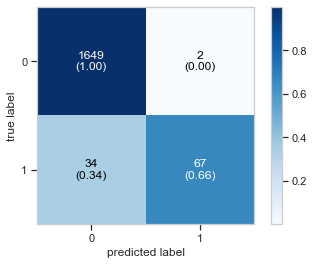

In [49]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(preds_probas_df_all_feat.y_true_values, preds_probas_df_all_feat.y_predicted_values),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

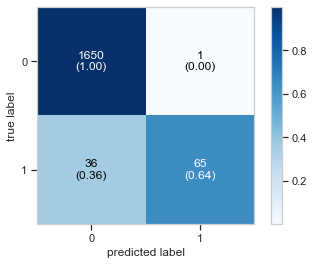

In [36]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(preds_probas_df_th_3.y_true_values, preds_probas_df_th_3.y_predicted_values),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

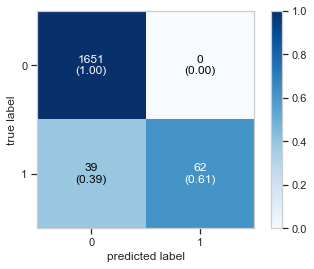

In [37]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(preds_probas_df_th_4.y_true_values, preds_probas_df_th_4.y_predicted_values),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

## Determinación del área bajo la curva ROC de cada clasificador

In [51]:
from sklearn.metrics import roc_auc_score

print('roc_auc_score con validation set all features: ', roc_auc_score(y_test, 
      preds_probas_df_all_feat.y_predicted_probas))

print('roc_auc_score con validation set threshold 3: ', roc_auc_score(y_test, 
      preds_probas_df_th_3.y_predicted_probas))

print('roc_auc_score con validation set threshold 4: ', roc_auc_score(y_test, 
      preds_probas_df_th_4.y_predicted_probas))

roc_auc_score con validation set all features:  0.9944468099141835
roc_auc_score con validation set threshold 3:  0.9924588158391854
roc_auc_score con validation set threshold 4:  0.9966896750244377


## Vemos que con valores de área bajo la curva ROC casi idénticas, tenemos matrices de confusión ligeramente diferentes; éstas se han construido con el threshold de decisión por defecto. En este caso, vamos a plotear las probabilidades de decisión predichas por cada uno, con lo cual podremos ver qué clasificador aporta más seguridad en sus predicciones (esto es, cuál tiene más casos de altas probas)

## Plot de la distribución de probabilidades de nuestros clasificadores

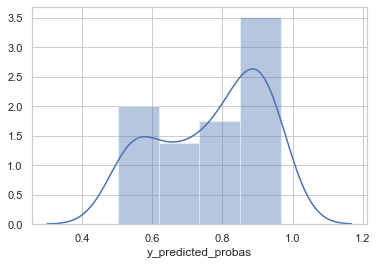

In [53]:
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.distplot(positive_preds_probas_df_all_feat.y_predicted_probas)

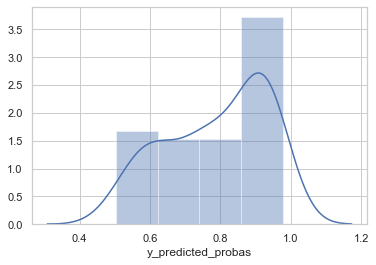

In [54]:
sns.set(style="whitegrid")

ax = sns.distplot(positive_preds_probas_df_th_3.y_predicted_probas)

### Y éste al último de selección de atributos con thres. 0.4

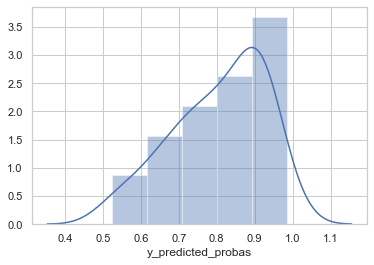

In [55]:
sns.set(style="whitegrid")

ax = sns.distplot(positive_preds_probas_df_th_4.y_predicted_probas)

# SE VE CLARAMENTE UNA MEJOR DISTRIBUCIÓN DE PROBABILIDADES DE PREDICCIÓN EN EL TERCER CASO, DONDE ADEMÁS DE TENER MÁS FRECUENCIAS DE OCURRENCIA EN PROBABILIDADES ENTRE 0.7 Y 0.9, TIENE MÁS CASOS EN LA PROBABILIDAD MÁS FRECUENTE, QUE ES 0.9 EN AMBOS CASOS; NO OBSTANTE, LA DIFERENCIA EN LAS DISTRIBUCIONES DE PROBABILIDAD ES MUY EVIDENTE PARA LA ÍNFIMA DIFERENCIA EN ROC_AUC, QUIZÁS UTILIZANDO COMO MÉTRICA EL ÁREA BAJO LA CURVA PRECISION-RECALL SE VEA MÁS CLARA LA DIFERENCIA

In [2]:
jupyter nbconvert --to html first_project_edp_cost_function_boiler_Y_right_tag_auc_probas_check.ipynb  

SyntaxError: invalid syntax (<ipython-input-2-8ebbeaa4488c>, line 1)